In [1]:
import pandas as pd
import polars as pl

tweets = pl.read_parquet('./master_fnn.parquet')
users = pl.read_csv('../database/master_users.csv')

In [2]:
data = tweets.select([
    pl.col('label'),
    pl.col('processed_text'),
])

In [3]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from gensim.models import Word2Vec, word2vec
from sklearn import metrics
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer,
                                             TfidfVectorizer)
from sklearn.manifold import TSNE
from sklearn.metrics import auc, confusion_matrix, roc_curve
from sklearn.preprocessing import StandardScaler

In [4]:
# Setting
WORD_COUNT = 5000
EXTRACT_COUNT = 5000

In [5]:
df = tweets.select([
    pl.col('label'),
    pl.col('processed_text'),
]).sample(WORD_COUNT)
df

shape: (5000, 2)
┌───────┬───────────────────────────────────┐
│ label ┆ processed_text                    │
│ ---   ┆ ---                               │
│ str   ┆ list[str]                         │
╞═══════╪═══════════════════════════════════╡
│ true  ┆ ["kim", "kardashian", … "year"]   │
│ false ┆ ["calvin", "harris", … "swift"]   │
│ true  ┆ ["positive", "message", … "state… │
│ true  ┆ ["arrangement", "megan", … "l"]   │
│ …     ┆ …                                 │
│ true  ┆ ["enjoy", "white", … "panamacity… │
│ true  ┆ ["sofia", "richie", … "h"]        │
│ false ┆ ["sofia", "richie", … "future"]   │
│ false ┆ ["great", "point", … "meat"]      │
└───────┴───────────────────────────────────┘

## COUNT BOW

In [6]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(df['processed_text'].arr.join(' ').to_list())
print('Type: ', type(final_counts))
print('shape: ', final_counts.get_shape)
print('No. of unique words: ', final_counts.get_shape()[1])

Type:  <class 'scipy.sparse._csr.csr_matrix'>
shape:  <bound method spmatrix.get_shape of <5000x11274 sparse matrix of type '<class 'numpy.int64'>'
	with 52273 stored elements in Compressed Sparse Row format>>
No. of unique words:  11274


          Dim1        Dim2  label
0    1.5525311   1.6373343   true
1  -0.15863821  0.06300268  false
2  -0.74166155  -0.5298625   true
3   -0.1928092  0.06287184   true
4    1.4595416   1.1202118  false
(5000, 3)


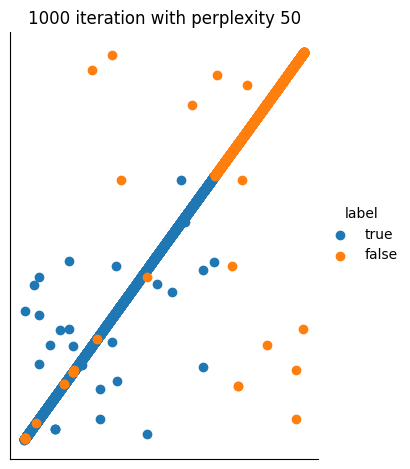

<Figure size 640x480 with 0 Axes>

In [7]:
from sklearn.manifold import TSNE

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)

data = final_counts[0:EXTRACT_COUNT,:].toarray()
std_data = scalar.fit_transform(data)
labels=df['label'].to_list()

labels = labels[0:EXTRACT_COUNT]

model = TSNE(n_components=2, random_state=2023, perplexity=50, n_iter=250)
tsne_data= model.fit_transform(std_data)

tsne_data= np.vstack((tsne_data.T, labels)).T
tsne_df= pd.DataFrame(tsne_data, columns=('Dim1','Dim2','label'))

print(tsne_df.head())
print(tsne_df.shape)

sns.FacetGrid(tsne_df, hue='label', height=5).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('1000 iteration with perplexity 50')

ax = plt.gca()

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()
plt.savefig('./output/tsne_bow_50_250.png')

         Dim1        Dim2  label
0   201.25606  -225.98677   true
1    -26.3804  -24.593859  false
2    -53.9485  -7.3547945   true
3  -282.43265    70.63053   true
4    325.3343   -64.56738  false
(5000, 3)


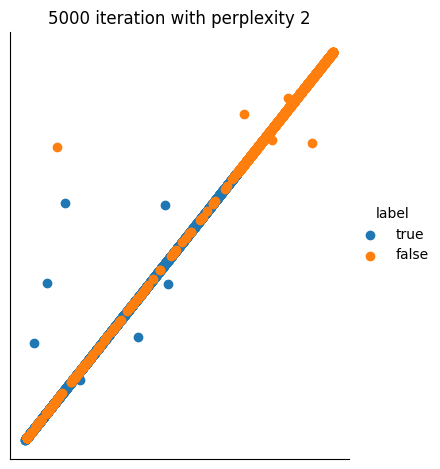

<Figure size 640x480 with 0 Axes>

In [8]:
from sklearn.manifold import TSNE

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)

data = final_counts[0:EXTRACT_COUNT,:].toarray()
std_data = scalar.fit_transform(data)
labels=df['label'].to_list()

labels = labels[0:EXTRACT_COUNT]

model = TSNE(n_components=2, random_state=2023, perplexity=2, n_iter=5000)
tsne_data= model.fit_transform(std_data)

tsne_data= np.vstack((tsne_data.T, labels)).T
tsne_df= pd.DataFrame(tsne_data, columns=('Dim1','Dim2','label'))

print(tsne_df.head())
print(tsne_df.shape)

sns.FacetGrid(tsne_df, hue='label', height=5).map(plt.scatter, 'Dim1','Dim2').add_legend()
plt.title('5000 iteration with perplexity 2')

ax = plt.gca()

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()
plt.savefig('./output/tsne_bow_2_5000.png')

## TFIDF

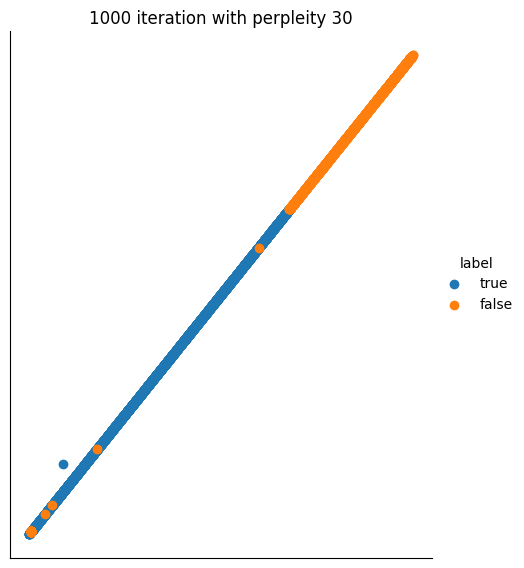

<Figure size 640x480 with 0 Axes>

In [9]:
tfidf_vect = TfidfVectorizer()
final_tfidf = tfidf_vect.fit_transform(df['processed_text'].arr.join(' ').to_list())

data = final_tfidf[0:EXTRACT_COUNT,:].toarray()
labels = df['label'].to_list()
labels = labels[0:EXTRACT_COUNT]

model = TSNE(n_components= 2, random_state= 2023, perplexity= 30)
tsne_data= model.fit_transform(data)

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(tsne_data, columns= ('Dim_1', 'Dim_2','label'))

sns.FacetGrid(tsne_df, hue= 'label', height=6).map(plt.scatter, 'Dim_1','Dim_2').add_legend()
plt.title('1000 iteration with perpleity 30')
ax = plt.gca()

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()
plt.savefig('./output/tsne_tfidf_2_250.png')

## Word2Vec

In [10]:
model_word2vec = Word2Vec.load('../model/output/word2vec.model')

In [11]:
text_list = df['processed_text'].to_list()

In [12]:
vocab = list(model_word2vec.wv.index_to_key )

In [13]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in text_list: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_word2vec.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5000
300


In [14]:
sent_vectors = np.array(sent_vectors)
print(type(sent_vectors))
sent_vectors = sent_vectors[0:EXTRACT_COUNT,:]
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
std_data = scalar.fit_transform(sent_vectors) 

<class 'numpy.ndarray'>


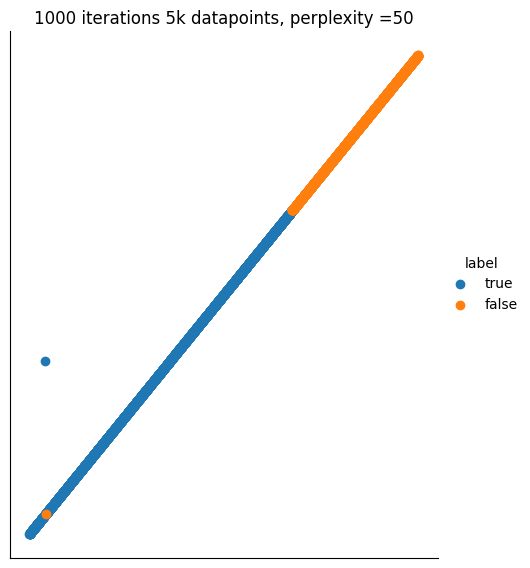

<Figure size 640x480 with 0 Axes>

In [15]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=2023, perplexity=50)
tsne_data = tsne_model.fit_transform(std_data)

labels = df["label"].to_list()
labels = labels[0:EXTRACT_COUNT]

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('1000 iterations 5k datapoints, perplexity =50')

ax = plt.gca()

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()
plt.savefig('./output/tsne_w2v.png')

## FastText

In [20]:
model_fasttext = Word2Vec.load('../model/output/fastText.model')

In [21]:
text_list = df['processed_text'].to_list()

KeyError: 'processed_text'

In [ ]:
vocab = list(model_fasttext.wv.index_to_key )

In [ ]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in text_list: # for each review/sentence
    sent_vec = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in vocab:
            vec = model_fasttext.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

5000
300


In [ ]:
sent_vectors = np.array(sent_vectors)
print(type(sent_vectors))
sent_vectors = sent_vectors[0:EXTRACT_COUNT,:]
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
std_data = scalar.fit_transform(sent_vectors) 

<class 'numpy.ndarray'>


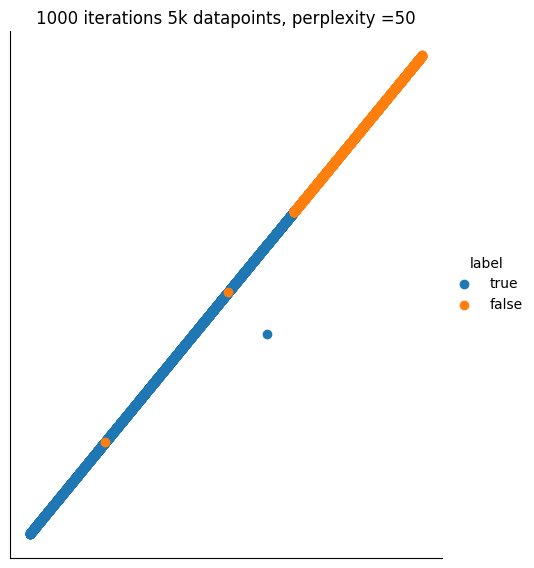

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=2023, perplexity=50)
tsne_data = tsne_model.fit_transform(std_data)

labels = df["label"].to_list()
labels = labels[0:EXTRACT_COUNT]

tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2','label'])

sns.FacetGrid(tsne_df, hue='label', height=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title('1000 iterations 5k datapoints, perplexity =50')

ax = plt.gca()

ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)

plt.show()
plt.savefig('./output/tsne_w2v.png')

In [16]:
tsne_model = TSNE(n_components=3, random_state=2023, perplexity=50)
tsne_data = tsne_model.fit_transform(std_data)
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(tsne_data, columns=['Dim_1','Dim_2', 'Dim_3','label'])
tsne_df

Dim_1       Dim_2       Dim_3  label
0      -8.710423   25.184767   13.480629   true
1      4.2589965  -12.146607   39.807777  false
2      -7.626174  -13.831607   -23.18735   true
3     -2.5283206    6.698033  -10.501995   true
4       2.249278   36.194714  -6.3867784  false
...          ...         ...         ...    ...
4995   0.3692737   14.859344    2.819257  false
4996   2.2035646   16.572443   -32.47997   true
4997   13.407961  0.40234447   14.284457   true
4998   22.774176    16.81162   -4.828847  false
4999  -1.7578307    2.255086  -18.507305  false

[5000 rows x 4 columns]

In [17]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(tsne_df, x='Dim_1', y='Dim_2', z='Dim_3',
              color='label')
fig.show()

In [18]:
from sklearn.decomposition import PCA

pca_model = PCA(n_components=3, random_state=2023)
pca_data = pca_model.fit_transform(std_data)
pca_data = np.vstack((pca_data.T, labels)).T
pca_df = pd.DataFrame(pca_data, columns=['Dim_1','Dim_2', 'Dim_3','label'])
pca_df

Dim_1                 Dim_2                 Dim_3  label
0      1.1159522270938083    2.1912131360961147   -1.6919715454759343   true
1       6.420493321548923    1.2965818260162587   -0.7422995508421162  false
2      -6.326742545571923  -0.04835810056606469    3.0281867228750583   true
3      -2.101867644626812    1.1935910596689614  -0.15777855329672472   true
4     -0.3899849398407267   -2.8394878765415332  -0.20890626485750716  false
...                   ...                   ...                   ...    ...
4995    5.360086400097853    1.7153461908065868    0.8776305525984213  false
4996   -4.852079969788766   -3.0225953190601107    0.9319735981811215   true
4997    4.709454778333838     1.305904083810087   -1.3719395772059926   true
4998   3.6768158756127955   -1.3198373469151898    3.6396943228143757  false
4999   -4.708896597310551    0.3831916233573633     4.178296878896447  false

[5000 rows x 4 columns]

In [19]:
import plotly.express as px
fig = px.scatter_3d(pca_df, x='Dim_1', y='Dim_2', z='Dim_3',
              color='label')
fig.show()